# Conditional GAN

Used to generate new training data for the ransomware families to overcome the skewed distribution of training data towards the benign samples

In [58]:
# Packages
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import os
from PIL import Image

**Change parameters**

-----

In [59]:
# Batch size
batch_size = 64

# Color mode
ch = 'grayscale'

# Image size
iw, ih = 64,64
im_size = (iw,ih)

# Latent dim size
latent_dim = 256

# Number of Epochs
epoch_t = 20

# Computation environment: Kaggle (0) or Local (1)
cenv = 1

# If weights are used: Weight factor
wf = 0.5

-----------

Automatic notebook preparation

In [60]:
if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

In [61]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/malimg_dataset"
    for files in os.listdir(dir):
        if "cgan" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: cgan-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"C://Users/Max/Documents/GitHub/malimg_dataset/cgan-local-v{new_vnum:03}"
    os.makedirs(new_dir)

9 matches(es) found
--------------
New folder name: cgan-local-v010
--------------


**Data preprocessing**

In [62]:
if cenv == 0:
    path_root = "/kaggle/input/data-wo-benign"
    path_save_imgs = "/kaggle/working/numpy_arrays/"
if cenv == 1:
    path_root = "C:/Users/Max/Documents/image_data/fixed_malimg_dataset"
    path_save_imgs = f"C:/Users/Max/Documents/image_data/malimg-cgan-local-v{new_vnum:03}"

In [63]:
datagen = ImageDataGenerator(
    rescale = 1/255)

In [64]:
prelim_dataset = datagen.flow_from_directory(
    directory = path_root,
    color_mode = ch,
    target_size = im_size,
    interpolation = 'bicubic',
    batch_size = 40000,
    shuffle=False
)
imgs, labels = next(prelim_dataset)

Found 9339 images belonging to 25 classes.


Ransomware family:  Lolyda.AT


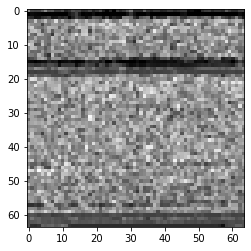

In [65]:
z = 7099+10
plt.imshow(np.array(imgs[z]*255).astype(np.uint8), cmap="gray")
print("Ransomware family: ",list(prelim_dataset.class_indices)[np.argmax(labels[z])])

In [66]:
num_samples = prelim_dataset.samples
num_classes = max(prelim_dataset.labels) + 1

In [67]:
prelim_dataset.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

Create tf.data.Dataset

In [68]:
dataset = tf.data.Dataset.from_tensor_slices((imgs, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

Calculate number of input channel for Gen and Disc

In [69]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = chnum + num_classes
print(generator_in_channels, discriminator_in_channels)

281 26


# Creating discriminator and generator

In [70]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((iw, ih, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)


In [71]:
# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(8 * 8 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [72]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        15040     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 256)             

In [73]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 17984)             5071488   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 17984)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 281)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 128)       575616    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 128)       0 

**Create Conditional GAN**

In [74]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[ih * iw]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, iw, ih, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

**Optimizers**

In [75]:
# Define optimizers
d_optimizer=keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer=keras.optimizers.Adam(learning_rate=0.0003)

**Checkpoints**

In [76]:
class GANMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        # Save the model every 5 epochs 
        if (epoch + 1) % 10 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

In [77]:
if cenv == 0:
    checkpoint_dir = '/kaggle/working/checkpoints'
if cenv == 1:
    checkpoint_dir = f'{new_dir}'
    
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=g_optimizer,
                                 discriminator_optimizer=d_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training C-GAN

In [78]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=epoch_t, 
        callbacks=GANMonitor()
)


Epoch 1/20
146/146 [==============================] - 22s 144ms/step - g_loss: 1.5739 - d_loss: 0.6622
Epoch 2/20
146/146 [==============================] - 21s 142ms/step - g_loss: 1.6294 - d_loss: 0.5966
Epoch 3/20
146/146 [==============================] - 22s 148ms/step - g_loss: 1.1542 - d_loss: 0.6704
Epoch 4/20
146/146 [==============================] - 21s 147ms/step - g_loss: 2.3941 - d_loss: 0.4523
Epoch 5/20
146/146 [==============================] - 22s 148ms/step - g_loss: 4.1994 - d_loss: 0.4368
Epoch 6/20
146/146 [==============================] - 22s 149ms/step - g_loss: 3.1842 - d_loss: 0.4153
Epoch 7/20
146/146 [==============================] - 22s 151ms/step - g_loss: 4.9417 - d_loss: 0.0719
Epoch 8/20
146/146 [==============================] - 23s 157ms/step - g_loss: 3.9047 - d_loss: 0.0806
Epoch 9/20
146/146 [==============================] - 22s 153ms/step - g_loss: 4.9714 - d_loss: 0.0367
Epoch 10/20
146/146 [==============================] - 22s 151ms/step - g

# Interpolating between classes with the trained GEN

In [79]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 2000  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake



In [80]:
# Create new directory for saving folder
os.makedirs(path_save_imgs)

In [81]:
# Retrieve class name based on number
classes_list = list(prelim_dataset.class_indices)

In [82]:
for i in range(num_classes):
    class_name = classes_list[i]
    class_dir = f"{path_save_imgs}/{class_name}"
    os.makedirs(class_dir)
    start_class = i
    end_class = i
    fake_images = interpolate_class(start_class, end_class)
    fake_images *= 255
    converted_images = fake_images.astype(np.uint8)
    converted_images = tf.image.resize(converted_images, (64, 64)).numpy().astype(np.uint8)
    for j in range(num_interpolation):
        np_array = np.squeeze(converted_images[j], axis=2)
        im = Image.fromarray((np_array))
        im.save(f"{class_dir}/gen_imgs_{class_name}_{j}.png")    